In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

In [2]:
import zipfile
local_zip = 'Image_Super_Resolution.zip'
zipref = zipfile.ZipFile(local_zip, 'r')
zipref.extractall('/content')

In [3]:
os.listdir('/content/dataset')

['Raw Data', 'train', 'val']

In [4]:
os.listdir('/content/dataset/train')

['high_res', 'low_res']

In [5]:
# Define the transformations on the data
low_res_size = 128
high_res_size = 256

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])

In [6]:
transform_low

Compose(
    ToPILImage()
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [7]:
transform_high

Compose(
    ToPILImage()
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [8]:
class ImageDataset(Dataset):
    # This is a custom dataset created using pytorch Dataset
    def __init__(self, root_dir):
        super(ImageDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "low_res"))
        files_high = os.listdir(os.path.join(root_dir, "high_res"))
        self.data = list(zip(files_low, files_high))

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        
        # Get the path for the image LR and HR
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)

        # Open the actual image
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]
        
        # Apply the transformation to the image
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)
        
        return low_res, high_res

In [9]:
def show_image():
    dataset = ImageDataset(root_dir="/content/dataset/train")
    loader = DataLoader(dataset, batch_size=128, num_workers=0)
    # Rest of your code

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for idx, (low_res, high_res) in enumerate(loader):
        # Display the first image in the left subplot
        axs[0].imshow(low_res[0].permute(1, 2, 0))
        axs[0].set_title("low res")

        # Display the second image in the right subplot
        axs[1].imshow(high_res[0].permute(1, 2, 0))
        axs[1].set_title("high res")
        
        if(idx == 0):
            break
            
    # Show the figure
    plt.show()     

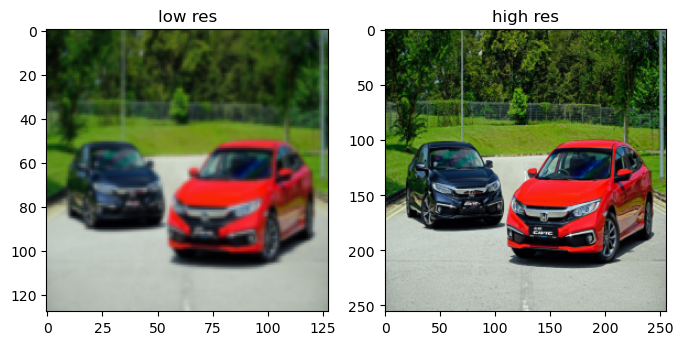

In [10]:
show_image()

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
epochs = 30
batch_size = 16
num_workers = 2
img_channels = 3

In [12]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

In [13]:
vgg_loss = vggL()

C:\Users\ajeet\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ajeet\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
vgg_loss

vggL(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [15]:
class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(
            self,
            in_channels,
            out_channels,
            use_activation=True,
            use_BatchNorm=True,
            **kwargs
    ):
        
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = (
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2

In [16]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [18]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2)) 
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

In [19]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super(Generator, self).__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2)) 
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))


In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

In [21]:
def plot_examples(gen):
    dataset_test = ImageDataset(root_dir="/content/dataset/val")
    loader = DataLoader(dataset, batch_size=128, num_workers=4)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)
        
            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")

            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
        
            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")
        
            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")
        
            if(idx == 1):
                break
            
    # Show the figure
    plt.show()      
    
    gen.train()

In [22]:
import random

def plot_examples(gen):
    dataset_test = ImageDataset(root_dir="/content/dataset/val")
    loader = DataLoader(dataset_test, batch_size=128, num_workers=0)
    
    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle("Example Predictions", fontsize=16)

    with torch.no_grad():
        # Choose a random batch
        chosen_batch = random.randint(0, len(loader)-1)
        for idx, (low_res, high_res) in enumerate(loader):
            if idx == chosen_batch:
                # Choose a random sample from the batch
                chosen_sample = random.randint(0, len(low_res)-1)

                axs[0].set_axis_off()
                axs[0].imshow(low_res[chosen_sample].permute(1, 2, 0))
                axs[0].set_title("Low Resolution")

                upscaled_img = gen(low_res[chosen_sample].to(device).unsqueeze(0))

                axs[1].set_axis_off()
                axs[1].imshow(upscaled_img.cpu().squeeze().permute(1, 2, 0))
                axs[1].set_title("Predicted High Resolution")

                axs[2].set_axis_off()
                axs[2].imshow(high_res[chosen_sample].permute(1, 2, 0))
                axs[2].set_title("Ground Truth High Resolution")

                break  # Only visualize one batch

    # Show the figure
    plt.show()

    gen.train()


In [23]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_progress(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(d_losses,label="Discriminator loss")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

In [24]:
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

In [25]:
# the data loaders for training and validation
train = ImageDataset(root_dir="/content/dataset/train")
train_loader = DataLoader(train, batch_size=128, num_workers=0)

val = ImageDataset(root_dir="/content/dataset/val")
val_loader = DataLoader(val, batch_size=128, num_workers=0)

In [26]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
        disc_loss = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

            
    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

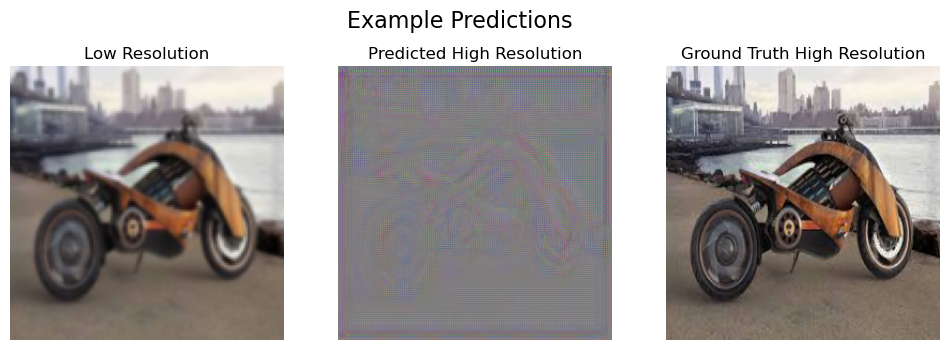

epoch  1 / 30


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
d_losses = []
g_losses = []
for epoch in range(epochs):
    plot_examples(gen)
    print("epoch ", epoch+1, "/", epochs)
    gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
     # train discriminator and generator and update losses
    d_losses.append(disc_loss)
    g_losses.append(gen_loss)
     